# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

import pinkfish as pf

# Format price data.
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots.
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

use_adj=True

Prepare timeseries

In [4]:
# Fetch and select timeseries.
ts = pf.fetch_timeseries(symbol,)
ts = pf.select_tradeperiod(ts, start, end, use_adj=use_adj)

# Add technical indicator: day sma regime filter.
ts['regime'] = \
    pf.CROSSOVER(ts, timeperiod_fast=50, timeperiod_slow=200)

# Finalize the time series before implementing trading strategy.
ts, start = pf.finalize_timeseries(ts, start, dropna=True, drop_columns=['open', 'high', 'low'])

# Create Trade Log (tlog); Create Daily Balance (dbal).
tlog = pf.TradeLog(symbol)
dbal = pf.DailyBal()

In [5]:
# Yahoo S&P 500 timeseries has issues, specifically some of the intraday value are 0.
# drop_columns removes these, then dropna drops the first 200 rows with regime value
# that are NA. pf.find_nan_rows() can help diagnose these issues.
df = pf.find_nan_rows(ts)
df

,close,adj_close,volume,regime
date,,,,


Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [6]:
pf.TradeLog.cash = capital

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime() 
    end_flag = pf.is_last_row(ts, i)

    # Buy
    # Note ts['regime'][i-1] is regime for previous day.
    # We want to buy only on the day of a moving average crossover.
    # i.e. yesteraday regime is negative, today it is positive.
    if tlog.shares == 0:
        if row.regime > 0 and ts['regime'].iloc[i-1] < 0:
            tlog.buy(date, row.close)  
    # Sell
    else:
        if row.regime < 0 or end_flag:
            tlog.sell(date, row.close)

    # Record daily balance.
    dbal.append(date, row.close)       

Retrieve logs

In [7]:
tlog = tlog.get_log()
dbal = dbal.get_log(tlog)

View trade log

In [8]:
tlog.head(50)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
0,1932-09-19,7.34,1933-03-27,6.09,-1.25,-1702.50,1362,-1702.50,LONG,^GSPC
1,1933-05-18,8.89,1934-05-31,9.61,0.72,671.76,933,-1030.74,LONG,^GSPC
2,1935-05-23,10.07,1937-05-21,16.27,6.20,5518.00,890,4487.26,LONG,^GSPC
3,1938-07-27,12.25,1939-03-31,10.98,-1.27,-1501.14,1182,2986.12,LONG,^GSPC
4,1939-09-18,12.47,1940-03-20,12.14,-0.33,-343.53,1041,2642.59,LONG,^GSPC
5,1940-12-13,10.69,1941-02-21,9.76,-0.93,-1099.26,1182,1543.33,LONG,^GSPC
6,1941-08-18,10.13,1941-11-18,9.26,-0.87,-990.93,1139,552.40,LONG,^GSPC
7,1942-08-14,8.58,1943-12-01,11.13,2.55,3133.95,1229,3686.35,LONG,^GSPC
8,1944-03-13,12.24,1946-08-28,16.73,4.49,5019.82,1118,8706.17,LONG,^GSPC
9,1947-07-25,16.08,1948-01-22,14.42,-1.66,-1930.58,1163,6775.59,LONG,^GSPC


Generate strategy stats - display all available stats

In [9]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                   1928-10-16
end                                                     2025-01-30
beginning_balance                                            10000
ending_balance                                          4160574.04
total_net_profit                                        4150574.04
gross_profit                                            4505435.38
gross_loss                                              -354861.34
profit_factor                                                12.70
return_on_initial_capital                                 41505.74
annual_return_rate                                            6.46
trading_period                           96 years 3 months 14 days
pct_time_in_market                                           66.55
margin                                                           1
avg_leverage                                                  1.00
max_leverage                                                  

Benchmark: Run, retrieve logs, generate stats

In [10]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj=use_adj)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

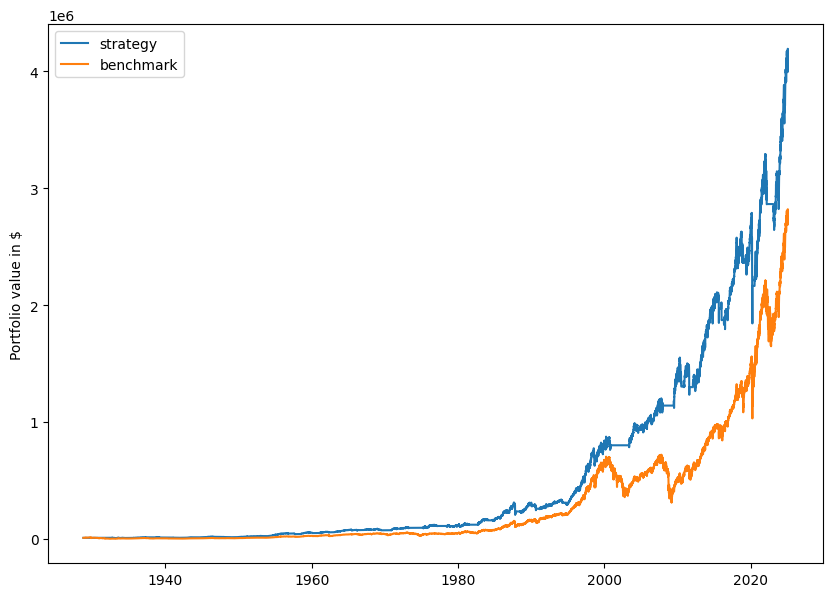

In [11]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

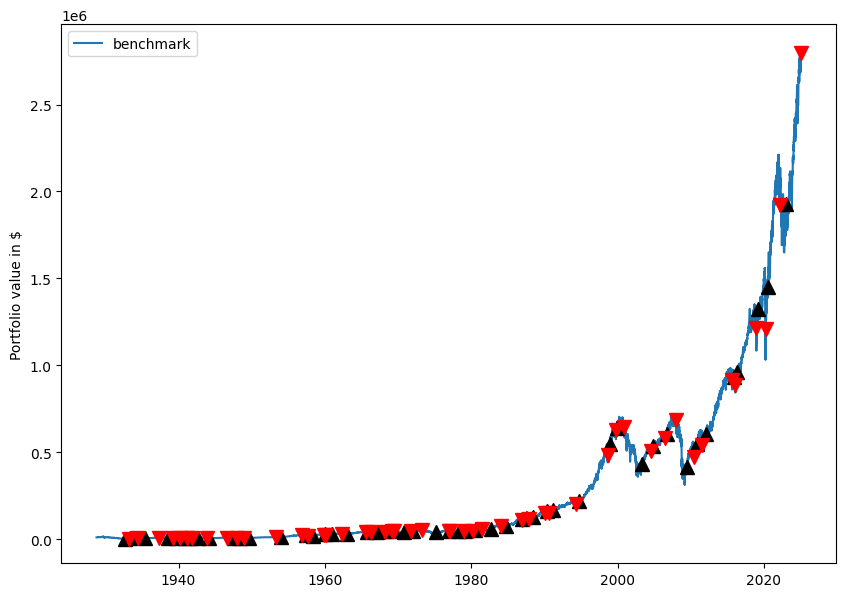

In [12]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Strategy vs Benchmark

In [13]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$4,160,574.04","$2,798,810.57"
total_net_profit,"$4,150,574.04","$2,788,810.57"
gross_profit,"$4,505,435.38","$2,788,810.57"
gross_loss,"-$354,861.34",$0.00


,strategy,benchmark
annual_return_rate,6.46,6.03
max_closed_out_drawdown,-36.86,-86.16
annualized_return_over_max_drawdown,0.18,0.07
best_month,22.49,61.49
worst_month,-30.91,-42.17
sharpe_ratio,0.55,0.40
sortino_ratio,0.55,0.51
monthly_std,3.28,5.31
annual_std,13.14,19.93
avg_month,0.55,0.61


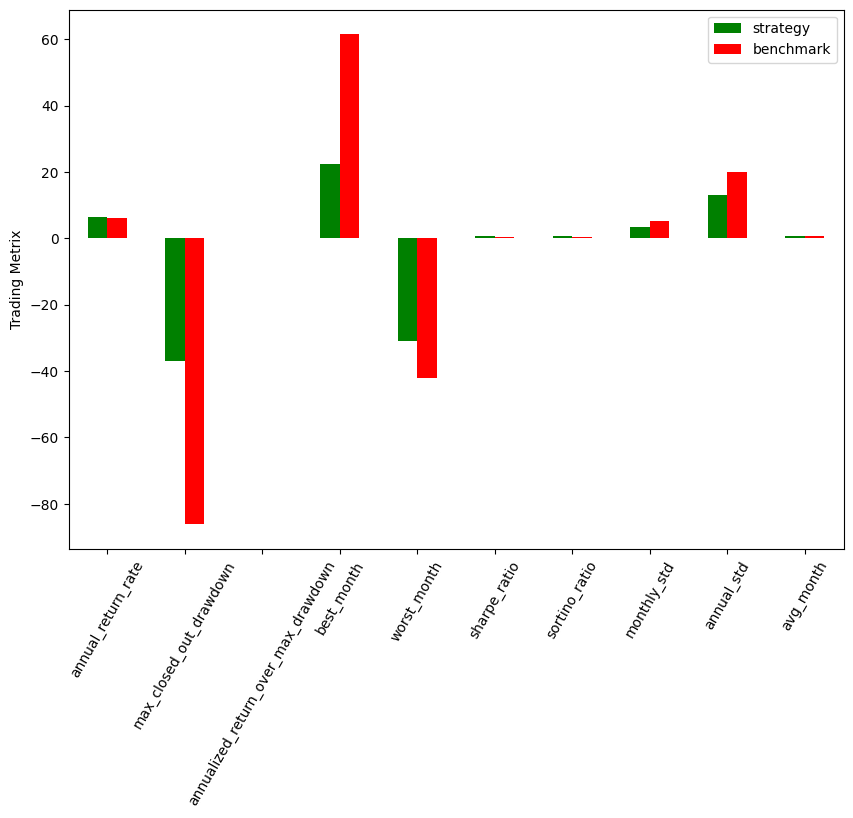

In [14]:
extras = ('avg_month',)

df = pf.plot_bar_graph(stats, benchmark.stats, extras=extras)
df